In [1]:
pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as numpy

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

from torchvision import datasets

import matplotlib.pyplot as plt

# Regression Task

## Generate Data

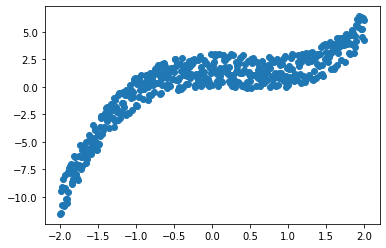

In [3]:
x = torch.linspace(-2, 2, 500)
y = x.pow(3) - x.pow(2) + 3*torch.rand(x.size()) ## 파이썬 제곱 함수: pow
# y = x^3 - x^2 + 3*e

x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

## Define Model

- single layer에 node의 수가 100개인 Single Layer NN model

- 단, 여기서 weight들은 어떤 고정값을 갖는 것이 아니라 BNN이기 때문에 분포를 띄고 있어야하므로 bnn의 BayesLinear 함수 사용

In [4]:
# prior_mu와 prior_sigma는 분포를 이미 gaussian으로 설정했기 때문에 분포를 정의하기 위한 parameter
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1)
)


# 손실함수
mse_loss = nn.MSELoss()

# Loss for calculating KL-divergence of BNN model

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

### BKLLoss함수에서의 parameter
- reduction: Specifies the reduction to apply to the output
  - 'mean'
  - 'sum'

- last_layer_only: True for return only the last layer's KL-divergence

## Train Model

In [5]:
kl_weight = 0.1
epoch = 3000

for step in range(epoch):

  optimizer.zero_grad()

  predict = model(x)
  mse = mse_loss(predict, y)
  kl = kl_loss(model)
  cost = mse + kl_weight*kl

  cost.backward()
  optimizer.step()

print('MSE : %2.2f, KL: %2.2f'%(mse.item(), kl.item()))


MSE : 0.91, KL: 5.53


- total cost function을 MSE loss에 일정 weight를 곱한 KL-divergence의 값을 더한 값

## Test Model

In [6]:
x_test = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3*torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

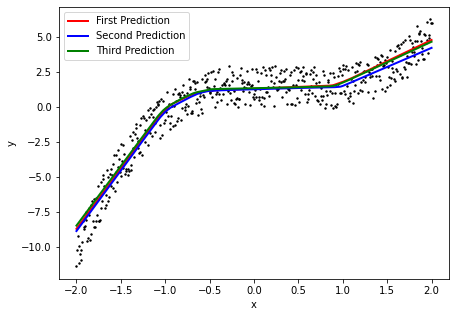

In [7]:
plt.figure(figsize=(7,5))

plt.xlabel('x')
plt.ylabel('y')

plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color='k', s=2)

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth=2, label='First Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth=2, label='Second Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth=2, label='Third Prediction')

plt.legend()

plt.show()

- 학습 완료 후, 모델에 fitting한 결과를 나타낸 것
- 3번의 output을 생성하여 fitting한 결과인데, 세 번 각기 다른 모델인 것을 알 수 있음
  - 아주 근소한 차이로 다른 모델인 것
- BNN은 weight가 분포로써 존재하기 때문에 그런 것
  - 같은 input이라 할지라도 매번 결과가 다르게 나옴

# Classification Task

## Load Task

In [ ]:
from sklearn.datasets import load_iris
import torch.utils.data as data_utils
from torch.utils.data import DataLoader

In [ ]:
iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [ ]:
x = iris.data
y = iris.target

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float().long()

x.shape, y.shape

(torch.Size([150, 4]), torch.Size([150]))

[Numpy에서 Tesor로 변환]: torch.Tensor() vs. torch.from_numpy()

- torch.Tensor()는 Numpy array의 사본
- tensor로 변환할 때 **새 메모리 할당**
- tensor의 값을 변경하더라도 Numpy array 자체의 값이 달라지지 않음

<br>


- torch.from_numpy()는 자동으로 input array의 dtype을 상속받고 tensor와 메모리 버퍼를 공유하기 때문에 tensor의 값이 변경되면 numpy array값이 변경


## Define Model

In [ ]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100), #변수(feature)가 4개
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=3) # target: 0, 1, 2
)

ce_loss = nn.CrossEntropyLoss() # 분류 모델에서는 손실함수를 crossentropyloss 사용
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

optimizer = optim.Adam(model.parameters(), lr=0.01)

## Train Model

In [ ]:
kl_weight = 0.1
epoch = 3000

for step in range(3000):

  optimizer.zero_grad()

  predict = model(x)

  ce = ce_loss(predict, y)
  kl = kl_loss(model)

  cost = ce + kl*kl_weight

  cost.backward()
  optimizer.step()

In [ ]:
torch.max(predict.data, dim=1)

torch.return_types.max(
values=tensor([10.1126,  8.9393,  9.3170,  8.4324, 10.1578,  9.7939,  8.9628,  9.5125,
         8.0864,  9.1306, 10.5925,  8.9575,  9.1006,  9.1510, 12.1782, 11.6493,
        10.8958,  9.8174, 10.3123, 10.0735,  9.4804,  9.5991, 10.3449,  7.9751,
         8.0720,  8.4991,  8.6385,  9.9624, 10.0661,  8.4623,  8.4163,  9.4595,
        11.1997, 11.7045,  8.8362,  9.9887, 10.9075, 10.2759,  8.5515,  9.6473,
         9.9668,  7.0921,  8.9117,  8.2164,  8.6212,  8.5099, 10.0827,  8.8976,
        10.4576,  9.6168,  3.4492,  3.0955,  3.1186,  2.4333,  2.8500,  2.5863,
         2.8921,  2.7897,  3.1596,  2.4609,  2.4916,  2.8282,  2.9551,  2.6953,
         3.0992,  3.3677,  2.4662,  3.0906,  2.3324,  2.8614,  2.3374,  3.1219,
         2.3579,  2.8177,  3.2033,  3.2426,  3.0152,  2.6931,  2.6560,  3.3053,
         2.7930,  2.9418,  3.0194,  2.7213,  2.3392,  2.8810,  3.1059,  2.7014,
         2.8755,  2.5572,  2.4850,  2.8139,  2.9008,  2.7908,  2.6311,  2.9724,
         

In [ ]:
_, predicted = torch.max(predict.data, dim=1)
total = y.size(0)

correct = (predicted==y).sum()

print("Accuracy: %f %%"%(100*float(correct)/total))
print("Cross Entropy: %2.2f, KL: %2.2f"%(ce.item(),kl.item()))

Accuracy: 94.666667 %
Cross Entropy: 0.12, KL: 1.28


In [ ]:
#softmax = torch.nn.functional.softmax(predict)
#total_predict = torch.argmax(softmax, dim=1)
#total_predict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Test Model

In [ ]:
def draw_plot(predicted):

  fig = plt.figure(figsize=(16,5))

  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  z1_plot = ax1.scatter(x[:, 0], x[:, 1], c=y)
  z2_plot = ax2.scatter(x[:, 0], x[:, 1], c=predicted)

  plt.colorbar(z1_plot, ax=ax1)
  plt.colorbar(z2_plot, ax=ax2)

  ax1.set_title('REAL')
  ax2.set_title('PREDICT')

  plt.show()

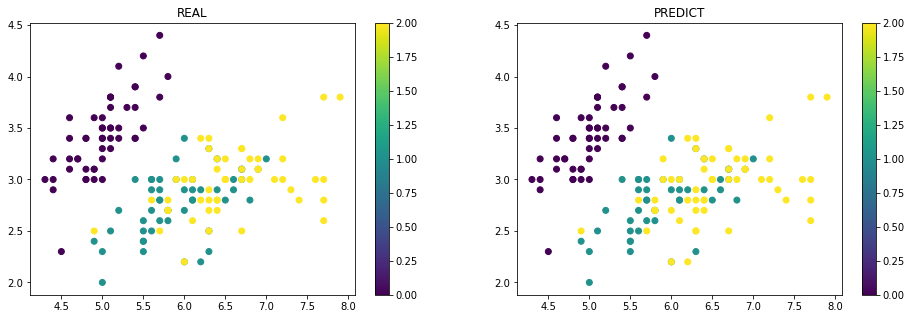

In [ ]:
predict = model(x)
_, predicted = torch.max(predict.data, 1)
draw_plot(predicted)

- 분류가 잘 된 것을 확인